,Predicts,Precision,Recall,F1-score,F2-score,AUC-PR,MMR,Sensitivity,PPP,Accuracy,F-Match,Separation
Method,,,,,,,,,,,,
CUBCO+,1679.55,0.383829,0.889706,0.534834,0.484942,0.440587,0.800672,0.862978,0.608445,0.724157,0.939788,0.312506
ClusterOne,190.50,0.932472,0.603350,0.732444,0.427324,0.483381,0.462726,0.826355,0.668715,0.743347,0.689542,0.646027
P5COMP,20956.55,0.834392,0.902369,0.866633,0.593353,0.637345,0.856026,0.926421,0.599025,0.744105,0.948366,0.085500
PC2P,261.50,0.934392,0.798162,0.860808,0.545324,0.637047,0.640324,0.893311,0.710163,0.796441,0.881904,0.791374


,GldStd,PPIN,Method,Precision,Recall
0,CYC,Collins,P5COMP,0.844405,0.634804
1,CYC,Collins,PC2P,0.904306,0.531863
2,CYC,Collins,CUBCO+,0.461002,0.928922
3,CYC,Collins,ClusterOne,0.968000,0.367647
4,CYC,Gavin,P5COMP,0.852775,0.536765


<Axes: xlabel='Precision', ylabel='Recall'>

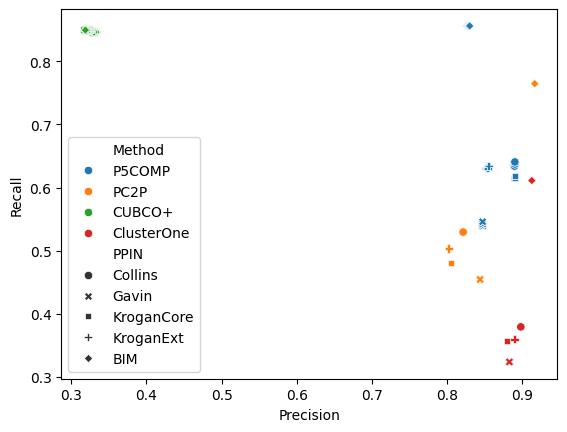

In [2]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("results/results_ok.csv")
df.drop(['GldStd', 'PPIN', 'Refs'], axis=1).groupby(by=['Method']).mean()

avg_scores = df[df.PPIN == 'BIM'].drop(['GldStd', 'PPIN', 'Refs'], axis=1).groupby(by=['Method']).mean()

display(avg_scores)

tdf = df.filter(["GldStd", "PPIN", "Method", "Precision", "Recall"],axis=1)
display(tdf.head())
sns.scatterplot(data=tdf[tdf.GldStd == "SGD"], x="Precision", y="Recall", hue="Method", style="PPIN")

In [20]:
from pathlib import Path
def find_overlapping_proteins(path):   
    with open(path) as f:
        lines = f.readlines()
        for i1 in range(len(lines)):
            proteins1 = lines[i1].split()
            for p1 in proteins1:
                for i2 in range(i1+1, len(lines)):
                    if i1 == i2:
                        continue
                    proteins2 = lines[i2].split()
                    for p2 in proteins2:
                        if p1 == p2:
                            print(i1, i2, ":", p1, p2)

def has_overlaps(c1, c2):
    for prot_u in c1.split():
        for prot_v in c2.split():
            if prot_u == prot_v:
                return True
    else:
        return False

def filter_to_overlapping_complexes(path: Path):
    overlapping_complexes = []
    with open(path) as f:
        lines = f.readlines()
        lines = [line.strip(' \n') for line in lines]
        for i, ci in enumerate(lines):
            for j, cj in enumerate(lines):
                if i == j:
                    continue
                if has_overlaps(ci, cj):
                    overlapping_complexes.append(ci)
                    break
    # print(overlapping_complexes)
    outfile = Path("data/Human/Corum_complexes-overlaps.txt")
    with outfile.open("w+") as f:
        for line in overlapping_complexes:
            f.write(line)
            f.write('\n')
                            
# find_overlapping_proteins("data\Yeast\CYC_complexes.txt")
# find_overlapping_proteins("data\Yeast\SGD_complexes.txt")

# filter_to_overlapping_complexes("data/Yeast/SGD_complexes.txt")

In [19]:
# Preprocess PIPS
from pathlib import Path

def preprocess(path: Path):
    output = Path("data/Human/PIPS/PIPS_New_Processed.txt")
    with path.open() as f, output.open('w+') as out:
        lines = f.readlines()
        for i, raw in enumerate(lines):
            if i == 1:
                continue
            line = raw.split()
            u, v, w = line[0], line[2], line[4]
            out.write(f"{u} {v} {w}\n")
            
            
preprocess(Path("data/Human/PIPS/PIPS_New.txt"))
filter_to_overlapping_complexes(Path("data/Human/Corum_complexes.txt"))

In [2]:
# Getting table topological properties
import networkx as nx
from pathlib import Path

# ppin = Path("data/Yeast/Collins/collins2007.txt")
# ppin = Path("data/Yeast/Gavin/gavin2006_socioaffinities_rescaled.txt")
# ppin = Path("data/Yeast/KroganCore/krogan2006_core.txt")
# ppin = Path("data/Yeast/KroganExt/krogan2006_extended.txt")
ppin = Path("eval/BIM.txt")

def rel_connectivity(G: nx.Graph):
    largest_cc = max(nx.connected_components(G), key=len)
    H = G.subgraph(largest_cc)
    f = H.number_of_nodes() / G.number_of_nodes()
    return f

def get_ppin_properties(path: Path):
    G: nx.Graph = nx.read_weighted_edgelist(ppin, create_using=nx.Graph)
    print(nx.average_node_connectivity(G))
    
rel_connectivity(nx.read_weighted_edgelist(ppin))

0.9980119284294234

In [29]:
# Getting complex distribution
import networkx as nx
from pathlib import Path

complexfile = Path("data/Yeast/SGD_complexes.txt")

def has_overlaps(c1, c2):
    for prot_u in c1:
        for prot_v in c2:
            if prot_u == prot_v:
                return True
    else:
        return False

def get_overlaps(complexes: list):
    overlaps = set()
    for i, ci in enumerate(complexes):
        for j, cj in enumerate(complexes):
            if i == j:
                continue
            if has_overlaps(ci, cj):
                overlaps.add(ci)
                break
    return overlaps

with complexfile.open() as f:
    complexes = set(frozenset(line.strip(' \n').split()) for line in f)
    # get small complexes
    smalls = set(filter(lambda x: len(x) <= 2, complexes))
    
    # get complexes with overlaps
    overlaps = get_overlaps(complexes)
    overlaps = overlaps - smalls
    
    regulars = set()
    for complex in complexes:
        if complex not in smalls and complex not in overlaps:
            regulars.add(complex)


print("regular", len(regulars))
print("small", len(smalls))
print("overlaps", len(overlaps))
print("total", len(complexes))


regular 96
small 80
overlaps 140
total 316


In [6]:
# Convert predicted clusters set to an edge list (6/17/2024)
from pathlib import Path
def predicts_to_edgelist(predicts: Path, outfile: Path):
    f = predicts.open()
    edgelist = set()
    for line in f:
        cluster = line.strip(' \n').split(':')[1].split()
        for u in cluster:
            for v in cluster:
                if u == v:
                    continue
                edgelist.add((u,v) if u < v else (v,u))
    f.close()
    f = outfile.open('w')
    for e in edgelist:
        f.writelines(f"{e[0]} {e[1]}\n")
                
path = "data\Results\P5COMP\P5COMP-CYC-BIM_clusters.txt"
# path = "data\Results\P5COMP\P5COMP-CYC-Collins_clusters.txt"
output = "visuals.txt"
predicts_to_edgelist(Path(path), Path(output))


In [ ]:
def find_overlapping_proteins2(path):   
    with open(path) as f:
        lines = f.readlines()
        for i in range(len(lines)):
            lines[i] = lines[i].split(":")[1].strip()
        for i1 in range(len(lines)):
            proteins1 = lines[i1].split()
            for p1 in proteins1:
                for i2 in range(i1+1, len(lines)):
                    if i1 == i2:
                        continue
                    proteins2 = lines[i2].split()
                    for p2 in proteins2:
                        if p1 == p2:
                            print(i1, i2, ":", p1, p2)

find_overlapping_proteins2("code\PC2P\Results\FilteredRay\Collins_CYC_direct_Predicted_iter0.txt")

from pathlib import Path

pathlist = Path("code\PC2P\Results\FilteredSequential").glob('**/*.txt')
for path in pathlist:
    # because path is object not string
    path_in_str = str(path)   
    print(path_in_str)
    find_overlapping_proteins2(path_in_str)

In [ ]:
# Reformat Integrated dataset
from pathlib import Path

pathlist = Path("code/PC2P/Analysis/Integrated").glob("clusters*")
i = 0
for path in pathlist:
    with path.open() as f:
        filename = "Integrated_CYC_Yong_iter{}.txt".format(i)
        with open("code/PC2P/Results/YongAndWong/{}".format(filename), "w+") as out:
            for line in f:
                out.write("(" + line.split("(")[1])
    i += 1

In [ ]:
# Reformat Integrated dataset
from pathlib import Path

pathlist = Path("code/PC2P/Analysis/Integrated").glob("clusters*")
i = 0
for path in pathlist:
    with path.open() as f:
        filename = "Integrated_CYC_Yong_iter{}.txt".format(i)
        with open("code/PC2P/Results/YongAndWong/{}".format(filename), "w+") as out:
            for line in f:
                out.write("(" + line.split("(")[1])
    i += 1

In [ ]:
# 5-18-2024-A
# Built-in graph clustering in NetworkX
import networkx as nx
import matplotlib.pyplot as plt

G = nx.davis_southern_women_graph()  # Example graph
communities = nx.community.greedy_modularity_communities(G)

# Compute positions for the node clusters as if they were themselves nodes in a
# supergraph using a larger scale factor
supergraph = nx.cycle_graph(len(communities))
superpos = nx.spring_layout(G, scale=50, seed=429)

# Use the "supernode" positions as the center of each node cluster
centers = list(superpos.values())
pos = {}
for center, comm in zip(centers, communities):
    pos.update(nx.spring_layout(nx.subgraph(G, comm), center=center, seed=1430))

# Nodes colored by cluster
for nodes in communities:
    nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes, node_size=100)
nx.draw_networkx_edges(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)

plt.tight_layout()
plt.show()

In [ ]:
# 5-19-2024-A
# For extracting pids from negatomes, plugged to UniProt mapper
from pathlib import Path

negfile = Path('data/Negatome/S.cerevisiae_Negative_Constructed.csv')

pids = set()
with open(negfile) as f:
    for line in f:
        for pid in line.split(',')[:2]:
            pid = pid.strip()
            pids.add(pid)
            
print(pids)

writepath = Path('data/Negatome/negatome_3.txt')
if not writepath.is_file:
    writepath.mkdir(parents=True)
with open(writepath, 'w') as f:
    for pid in pids:
        f.write(f'{pid} ')
    f.write('\n')


In [ ]:
# 5-19-2024-B
# Rewriting negatomes to map PIDs to gene names
from pathlib import Path

mapfile = Path('data/Negatome/negatome_2_mix_uniprot-kegg-mapping.tsv')
negfile = Path('data/Negatome/negatome_2_mix.txt')

mapping = {}
with open(mapfile) as f:
    next(f)
    for line in f:
        uniprot = line.split()[0]
        kegg = line.split()[1].split(':')[1]
        mapping.update({uniprot: kegg})

# print(mapping)

negppin = []
with open(negfile) as f:
    for line in f:
        raw = line.split()[:2]      # can be ','
        negppin.append(tuple([raw[0].strip(), raw[1].strip()]))

print(mapping)
print(negppin)

negppin_new = []
for negppi in negppin:
    u, v = negppi[0], negppi[1]
    if u in mapping and v in mapping:
        u_new = mapping[u]
        v_new = mapping[v]
        negppin_new.append((u_new, v_new))
    
print(negppin_new)
            
# print(pids)

writepath = Path('data/Negatome/negatome_2_mix_mapped.txt')
if not writepath.is_file:
    writepath.mkdir(parents=True)
with open(writepath, 'x') as f:
    for negpair in negppin_new:
        f.write(f'{negpair[0]} {negpair[1]}\n')
